# Enable Agent Tutorial Part 2: YOLO Enable Agent 구현

## 개요

Part 1에서 학습한 YOLOv8 모델을 Enable Agent로 변환한다.


## 학습 내용

- YAML 기반 스킬 정의 파일 작성
- PlasticDetectionAgent 클래스 구현
- 탐지 결과 구조화 및 시각화
- OpenAI Function Calling 통합

---
## 1. 라이브러리 임포트

In [1]:
import os
import json
import yaml
import base64
from pathlib import Path
from datetime import datetime
from typing import Dict, Any, List, Union
from io import BytesIO

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from ultralytics import YOLO

from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
print("라이브러리 임포트 완료")

라이브러리 임포트 완료


---
## 2. YAML 스킬 파일 생성

In [2]:
skill_definition = {
    'agent_name': 'PlasticDetectionAgent',
    'version': '1.0.0',
    'description': '이미지에서 플라스틱 재활용 소재를 탐지하고 분류하는 객체 탐지 에이전트',
    
    'capabilities': {
        'primary': '이미지에서 PET, PS, PP, PE 플라스틱 소재를 탐지하고 위치를 반환한다',
        'secondary': [
            '다중 객체 탐지',
            '바운딩 박스 및 신뢰도 반환',
            '재활용 가이드 제공',
            '탐지 결과 시각화'
        ]
    },
    
    'classes': {
        0: {'name': 'pet', 'full_name': 'Polyethylene Terephthalate', 'recycle_code': '#1'},
        1: {'name': 'ps', 'full_name': 'Polystyrene', 'recycle_code': '#6'},
        2: {'name': 'pp', 'full_name': 'Polypropylene', 'recycle_code': '#5'},
        3: {'name': 'pe', 'full_name': 'Polyethylene', 'recycle_code': '#2,#4'}
    },
    
    'input_schema': {
        'type': 'object',
        'properties': {
            'image_path': {'type': 'string', 'description': '이미지 파일 경로'},
            'image_base64': {'type': 'string', 'description': 'Base64 인코딩된 이미지'},
            'confidence_threshold': {'type': 'number', 'default': 0.25, 'minimum': 0, 'maximum': 1},
            'iou_threshold': {'type': 'number', 'default': 0.45, 'minimum': 0, 'maximum': 1}
        }
    },
    
    'output_schema': {
        'type': 'object',
        'properties': {
            'detections': {
                'type': 'array',
                'items': {
                    'type': 'object',
                    'properties': {
                        'class_id': {'type': 'integer'},
                        'class_name': {'type': 'string'},
                        'confidence': {'type': 'number'},
                        'bbox': {'type': 'array', 'description': '[x1, y1, x2, y2]'},
                        'recycle_code': {'type': 'string'}
                    }
                }
            },
            'num_detections': {'type': 'integer'},
            'class_counts': {'type': 'object'},
            'timestamp': {'type': 'string'}
        }
    },
    
    'model_info': {
        'model_path': 'models/plastic_yolov8_best.pt',
        'metadata_path': 'models/yolo_metadata.json',
        'input_size': 640,
        'model_type': 'YOLOv8'
    }
}

Path('skills').mkdir(exist_ok=True)
skill_path = 'skills/yolo_agent_skill.yaml'

with open(skill_path, 'w', encoding='utf-8') as f:
    yaml.dump(skill_definition, f, default_flow_style=False, allow_unicode=True, sort_keys=False)

print(f"스킬 파일 생성 완료: {skill_path}")

스킬 파일 생성 완료: skills/yolo_agent_skill.yaml


In [3]:
with open(skill_path, 'r', encoding='utf-8') as f:
    print(f.read())

agent_name: PlasticDetectionAgent
version: 1.0.0
description: 이미지에서 플라스틱 재활용 소재를 탐지하고 분류하는 객체 탐지 에이전트
capabilities:
  primary: 이미지에서 PET, PS, PP, PE 플라스틱 소재를 탐지하고 위치를 반환한다
  secondary:
  - 다중 객체 탐지
  - 바운딩 박스 및 신뢰도 반환
  - 재활용 가이드 제공
  - 탐지 결과 시각화
classes:
  0:
    name: pet
    full_name: Polyethylene Terephthalate
    recycle_code: '#1'
  1:
    name: ps
    full_name: Polystyrene
    recycle_code: '#6'
  2:
    name: pp
    full_name: Polypropylene
    recycle_code: '#5'
  3:
    name: pe
    full_name: Polyethylene
    recycle_code: '#2,#4'
input_schema:
  type: object
  properties:
    image_path:
      type: string
      description: 이미지 파일 경로
    image_base64:
      type: string
      description: Base64 인코딩된 이미지
    confidence_threshold:
      type: number
      default: 0.25
      minimum: 0
      maximum: 1
    iou_threshold:
      type: number
      default: 0.45
      minimum: 0
      maximum: 1
output_schema:
  type: object
  properties:
    detections:
      type: array
  

---
## 3. PlasticDetectionAgent 클래스 구현

In [4]:
class PlasticDetectionAgent:
    """플라스틱 재활용 소재 탐지 Enable Agent"""
    
    # 클래스 색상
    CLASS_COLORS = {
        0: '#FF6B6B',  # PET - 빨강
        1: '#4ECDC4',  # PS - 청록
        2: '#45B7D1',  # PP - 파랑
        3: '#96CEB4'   # PE - 녹색
    }
    
    def __init__(self, skill_path: str):
        """Enable Agent를 초기화한다."""
        with open(skill_path, 'r', encoding='utf-8') as f:
            self.skill = yaml.safe_load(f)
        
        # YOLO 모델 로드
        model_path = self.skill['model_info']['model_path']
        if Path(model_path).exists():
            self.model = YOLO(model_path)
            print(f"YOLO 모델 로드 완료: {model_path}")
        else:
            # 기본 모델 사용 (데모용)
            self.model = YOLO('yolov8n.pt')
            print("기본 YOLOv8n 모델 로드 (학습된 모델 없음)")
        
        # 클래스 정보
        self.classes = self.skill['classes']
        self.class_names = {k: v['name'] for k, v in self.classes.items()}
        
        # OpenAI 클라이언트
        self.client = OpenAI()
        
        print(f"{self.skill['agent_name']} 초기화 완료")
    
    def get_capability_description(self) -> str:
        """에이전트의 기능을 자연어로 반환한다."""
        classes_desc = '\n'.join([
            f"  - {v['name'].upper()} ({v['full_name']}): 재활용 코드 {v['recycle_code']}"
            for v in self.classes.values()
        ])
        
        return f"""
Agent: {self.skill['agent_name']} v{self.skill['version']}
설명: {self.skill['description']}

주요 기능: {self.skill['capabilities']['primary']}
부가 기능: {', '.join(self.skill['capabilities']['secondary'])}

탐지 가능 클래스:
{classes_desc}

입력: 이미지 파일 경로 또는 Base64 인코딩 이미지
출력: 탐지된 객체 리스트 (클래스, 신뢰도, 바운딩 박스)
""".strip()
    
    def _load_image(self, image_path: str = None, image_base64: str = None) -> Image.Image:
        """이미지를 로드한다."""
        if image_path:
            return Image.open(image_path)
        elif image_base64:
            image_data = base64.b64decode(image_base64)
            return Image.open(BytesIO(image_data))
        else:
            raise ValueError("image_path 또는 image_base64 중 하나를 제공해야 한다.")
    
    def detect(self, 
               image_path: str = None, 
               image_base64: str = None,
               confidence_threshold: float = 0.25,
               iou_threshold: float = 0.45) -> Dict[str, Any]:
        """이미지에서 플라스틱 소재를 탐지한다."""
        
        # 이미지 로드
        if image_path:
            source = image_path
        else:
            img = self._load_image(image_base64=image_base64)
            source = np.array(img)
        
        # YOLO 추론
        results = self.model.predict(
            source=source,
            conf=confidence_threshold,
            iou=iou_threshold,
            verbose=False
        )
        
        # 결과 파싱
        detections = []
        class_counts = {name: 0 for name in self.class_names.values()}
        
        for result in results:
            for box in result.boxes:
                cls_id = int(box.cls[0])
                
                # 학습된 모델의 클래스만 처리
                if cls_id in self.classes:
                    cls_info = self.classes[cls_id]
                    
                    detection = {
                        'class_id': cls_id,
                        'class_name': cls_info['name'],
                        'full_name': cls_info['full_name'],
                        'confidence': float(box.conf[0]),
                        'bbox': box.xyxy[0].tolist(),  # [x1, y1, x2, y2]
                        'recycle_code': cls_info['recycle_code']
                    }
                    detections.append(detection)
                    class_counts[cls_info['name']] += 1
        
        return {
            'detections': detections,
            'num_detections': len(detections),
            'class_counts': class_counts,
            'image_size': results[0].orig_shape if results else None,
            'timestamp': datetime.now().isoformat()
        }
    
    def visualize(self, 
                  image_path: str, 
                  detection_result: Dict[str, Any],
                  save_path: str = None,
                  show: bool = True) -> None:
        """탐지 결과를 시각화한다."""
        img = Image.open(image_path)
        
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(img)
        
        for det in detection_result['detections']:
            x1, y1, x2, y2 = det['bbox']
            cls_id = det['class_id']
            cls_name = det['class_name'].upper()
            conf = det['confidence']
            color = self.CLASS_COLORS.get(cls_id, '#FFFFFF')
            
            # 바운딩 박스
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=3, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            
            # 라벨
            label = f"{cls_name} {conf:.0%}"
            ax.text(
                x1, y1 - 10, label,
                color='white', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.9)
            )
        
        ax.axis('off')
        title = f"탐지 결과: {detection_result['num_detections']}개 객체"
        plt.title(title, fontsize=14)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"시각화 저장: {save_path}")
        
        if show:
            plt.show()
        else:
            plt.close()
    
    def generate_explanation(self, detection_result: Dict[str, Any]) -> str:
        """탐지 결과에 대한 AI 설명을 생성한다."""
        detections = detection_result['detections']
        class_counts = detection_result['class_counts']
        
        if not detections:
            return "이미지에서 플라스틱 소재가 탐지되지 않았다."
        
        prompt = f"""
이미지에서 플라스틱 재활용 소재를 탐지한 결과를 설명해달라.

탐지 결과:
- 총 탐지 객체: {detection_result['num_detections']}개
- 클래스별 개수: {json.dumps(class_counts, ensure_ascii=False)}

탐지된 객체:
{chr(10).join([f"- {d['class_name'].upper()} ({d['full_name']}): 신뢰도 {d['confidence']:.1%}, 재활용 코드 {d['recycle_code']}" for d in detections])}

2-3문장으로 탐지 결과를 요약하고, 각 소재의 재활용 방법을 간략히 안내해달라.
문장은 ~다로 끝낸다.
"""
        
        response = self.client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=300
        )
        
        return response.choices[0].message.content
    
    def generate_tool_definition(self) -> Dict[str, Any]:
        """OpenAI Function Calling을 위한 도구 정의를 생성한다."""
        return {
            "type": "function",
            "function": {
                "name": "detect_plastic",
                "description": self.skill['description'],
                "parameters": {
                    "type": "object",
                    "properties": {
                        "image_path": {
                            "type": "string",
                            "description": "분석할 이미지 파일 경로"
                        },
                        "confidence_threshold": {
                            "type": "number",
                            "description": "신뢰도 임계값 (0-1)",
                            "default": 0.25
                        }
                    },
                    "required": ["image_path"]
                }
            }
        }
    
    def get_recycling_guide(self, class_name: str) -> str:
        """특정 플라스틱 소재의 재활용 가이드를 반환한다."""
        guides = {
            'pet': """PET (폴리에틸렌 테레프탈레이트) - 재활용 코드 #1
- 용도: 음료수 병, 식품 용기
- 재활용: 세척 후 라벨 제거, 압축하여 배출
- 주의: 고온에서 유해물질 방출 가능""",
            
            'ps': """PS (폴리스타이렌) - 재활용 코드 #6
- 용도: 스티로폼, 일회용 컵
- 재활용: 분리배출, 전용 수거함 이용
- 주의: 열에 약함, 재활용률 낮음""",
            
            'pp': """PP (폴리프로필렌) - 재활용 코드 #5
- 용도: 요거트 용기, 병뚜껑
- 재활용: 세척 후 분리배출
- 장점: 내열성 우수, 재활용 용이""",
            
            'pe': """PE (폴리에틸렌) - 재활용 코드 #2, #4
- 용도: 비닐봉투, 우유병
- 재활용: 세척 후 분리배출
- 종류: HDPE(고밀도), LDPE(저밀도)"""
        }
        
        return guides.get(class_name.lower(), "해당 소재의 정보가 없다.")

print("PlasticDetectionAgent 클래스 정의 완료")

PlasticDetectionAgent 클래스 정의 완료


---
## 4. Enable Agent 초기화 및 테스트

In [5]:
agent = PlasticDetectionAgent('skills/yolo_agent_skill.yaml')
print()
print(agent.get_capability_description())

YOLO 모델 로드 완료: models/plastic_yolov8_best.pt
PlasticDetectionAgent 초기화 완료

Agent: PlasticDetectionAgent v1.0.0
설명: 이미지에서 플라스틱 재활용 소재를 탐지하고 분류하는 객체 탐지 에이전트

주요 기능: 이미지에서 PET, PS, PP, PE 플라스틱 소재를 탐지하고 위치를 반환한다
부가 기능: 다중 객체 탐지, 바운딩 박스 및 신뢰도 반환, 재활용 가이드 제공, 탐지 결과 시각화

탐지 가능 클래스:
  - PET (Polyethylene Terephthalate): 재활용 코드 #1
  - PS (Polystyrene): 재활용 코드 #6
  - PP (Polypropylene): 재활용 코드 #5
  - PE (Polyethylene): 재활용 코드 #2,#4

입력: 이미지 파일 경로 또는 Base64 인코딩 이미지
출력: 탐지된 객체 리스트 (클래스, 신뢰도, 바운딩 박스)


In [6]:
# 테스트 이미지로 탐지 수행
test_images = list(Path('datasets/plastic/val/images').glob('*.jpg'))

if test_images:
    test_img = str(test_images[0])
    print(f"테스트 이미지: {test_img}")
    
    result = agent.detect(
        image_path=test_img,
        confidence_threshold=0.25
    )
    
    print("\n=== 탐지 결과 ===")
    print(json.dumps(result, indent=2, ensure_ascii=False))
else:
    print("테스트 이미지가 없다.")

테스트 이미지: datasets/plastic/val/images/plastic_test_021.jpg

=== 탐지 결과 ===
{
  "detections": [
    {
      "class_id": 0,
      "class_name": "pet",
      "full_name": "Polyethylene Terephthalate",
      "confidence": 0.8248674273490906,
      "bbox": [
        653.1790771484375,
        1704.5836181640625,
        823.5579833984375,
        1955.7554931640625
      ],
      "recycle_code": "#1"
    },
    {
      "class_id": 1,
      "class_name": "ps",
      "full_name": "Polystyrene",
      "confidence": 0.7578449249267578,
      "bbox": [
        580.9407958984375,
        1137.5009765625,
        1212.7080078125,
        1707.248046875
      ],
      "recycle_code": "#6"
    },
    {
      "class_id": 1,
      "class_name": "ps",
      "full_name": "Polystyrene",
      "confidence": 0.3190435767173767,
      "bbox": [
        362.2330017089844,
        645.3856811523438,
        660.1004638671875,
        1215.0755615234375
      ],
      "recycle_code": "#6"
    }
  ],
  "num_detec

/var/folders/v9/46y9d8bn1lxgjt7g439hsf8c0000gn/T/ipykernel_78525/3495394700.py:156: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v9/46y9d8bn1lxgjt7g439hsf8c0000gn/T/ipykernel_78525/3495394700.py:156: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v9/46y9d8bn1lxgjt7g439hsf8c0000gn/T/ipykernel_78525/3495394700.py:156: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v9/46y9d8bn1lxgjt7g439hsf8c0000gn/T/ipykernel_78525/3495394700.py:156: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v9/46y9d8bn1lxgjt7g439hsf8c0000gn/T/ipykernel_78525/3495394700.py:156: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/v9/46y9d8bn1lxgjt7g439hsf8c0000gn/T/

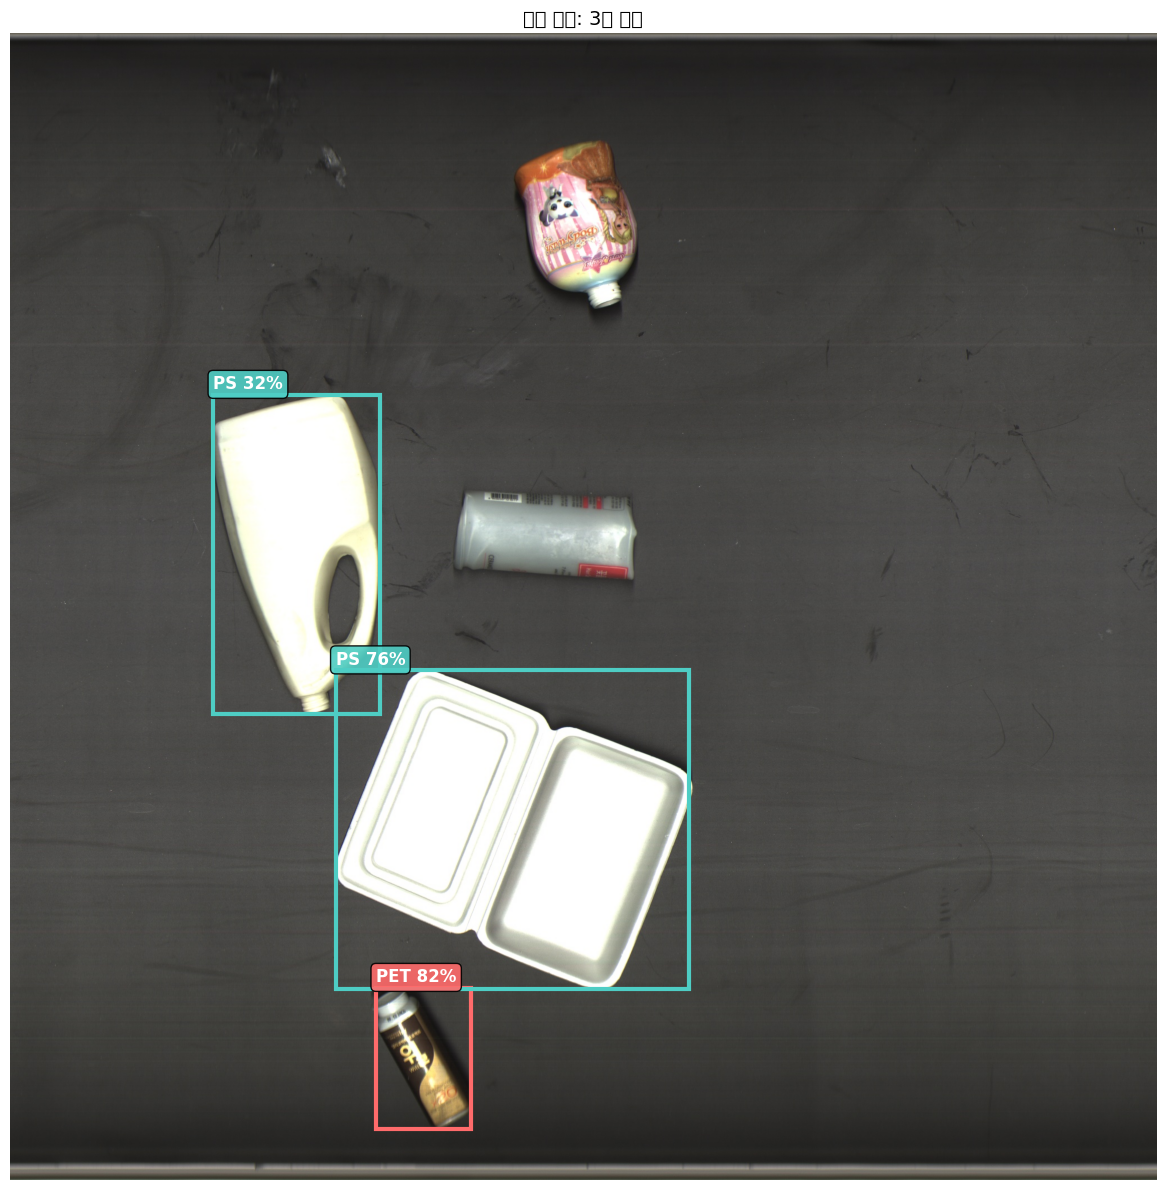

In [7]:
# 탐지 결과 시각화
if test_images and result['num_detections'] > 0:
    agent.visualize(test_img, result)

In [8]:
# AI 설명 생성
if result['num_detections'] > 0:
    print("=== AI 설명 ===")
    explanation = agent.generate_explanation(result)
    print(explanation)

=== AI 설명 ===
탐지 결과, 총 3개의 플라스틱 재활용 소재가 발견되었으며, PET이 1개, PS가 2개 포함되었다. PET은 신뢰도 82.5%로 잘 탐지되었고, PS는 각각 75.8%와 31.9%의 신뢰도로 탐지되었다. 

PET은 재활용 공장에서 세척 후 재가공되어 섬유나 음료수병 등으로 재탄생할 수 있으며, PS는 일반적으로 재활용이 어려워 매립되거나 에너지 회수로 처리되곤 한다.


---
## 5. 재활용 가이드 테스트

In [9]:
print("=== 재활용 가이드 ===")
for cls_name in ['pet', 'ps', 'pp', 'pe']:
    print()
    print(agent.get_recycling_guide(cls_name))
    print("-" * 50)

=== 재활용 가이드 ===

PET (폴리에틸렌 테레프탈레이트) - 재활용 코드 #1
- 용도: 음료수 병, 식품 용기
- 재활용: 세척 후 라벨 제거, 압축하여 배출
- 주의: 고온에서 유해물질 방출 가능
--------------------------------------------------

PS (폴리스타이렌) - 재활용 코드 #6
- 용도: 스티로폼, 일회용 컵
- 재활용: 분리배출, 전용 수거함 이용
- 주의: 열에 약함, 재활용률 낮음
--------------------------------------------------

PP (폴리프로필렌) - 재활용 코드 #5
- 용도: 요거트 용기, 병뚜껑
- 재활용: 세척 후 분리배출
- 장점: 내열성 우수, 재활용 용이
--------------------------------------------------

PE (폴리에틸렌) - 재활용 코드 #2, #4
- 용도: 비닐봉투, 우유병
- 재활용: 세척 후 분리배출
- 종류: HDPE(고밀도), LDPE(저밀도)
--------------------------------------------------


---
## 6. OpenAI Function Calling 통합

In [10]:
tool_definition = agent.generate_tool_definition()
print("=== Function Calling 도구 정의 ===")
print(json.dumps(tool_definition, indent=2, ensure_ascii=False))

=== Function Calling 도구 정의 ===
{
  "type": "function",
  "function": {
    "name": "detect_plastic",
    "description": "이미지에서 플라스틱 재활용 소재를 탐지하고 분류하는 객체 탐지 에이전트",
    "parameters": {
      "type": "object",
      "properties": {
        "image_path": {
          "type": "string",
          "description": "분석할 이미지 파일 경로"
        },
        "confidence_threshold": {
          "type": "number",
          "description": "신뢰도 임계값 (0-1)",
          "default": 0.25
        }
      },
      "required": [
        "image_path"
      ]
    }
  }
}


In [13]:
def chat_with_detector(user_message: str, image_path: str = None) -> str:
    """자연어로 플라스틱 탐지 에이전트와 대화한다."""
    client = OpenAI()
    tools = [agent.generate_tool_definition()]
    
    messages = [
        {
            "role": "system",
            "content": """당신은 플라스틱 재활용 분류 AI 어시스턴트다.
사용자가 이미지를 분석해달라고 하면 detect_plastic 함수를 호출한다.
탐지 결과를 친절하게 설명하고 재활용 방법을 안내한다.
문장은 ~다로 끝낸다."""
        },
        {"role": "user", "content": user_message}
    ]
    
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        tools=tools,
        tool_choice="auto"
    )
    
    msg = response.choices[0].message
    
    if msg.tool_calls:
        tool_call = msg.tool_calls[0]
        args = json.loads(tool_call.function.arguments)
        
        # 이미지 경로 설정
        if image_path:
            args['image_path'] = image_path
        
        # 탐지 수행
        detection_result = agent.detect(**args)
        
        messages.append({"role": "assistant", "content": None, "tool_calls": [tool_call]})
        messages.append({
            "role": "tool",
            "tool_call_id": tool_call.id,
            "name": "detect_plastic",
            "content": json.dumps(detection_result, ensure_ascii=False)
        })
        
        final_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages
        )
        
        return final_response.choices[0].message.content, detection_result
    
    return msg.content, None

In [14]:
if test_images:
    response, detection = chat_with_detector(
        "이 이미지에서 플라스틱 소재를 분석해줘.",
        image_path=str(test_images[0])
    )
    
    print("=== AI 응답 ===")
    print(response)

=== AI 응답 ===
분석할 이미지 파일 경로를 제공해주시면, 플라스틱 소재를 탐지하여 결과를 설명해드리겠다.
